
The feature selection notebook does a filter followed by a wrapper. It's capable of doing the filter on more than one file. The variable files are called vars1.csv, vars2.csv ...

The filter runs separately on each vars file and keeps the top num_filter variables from each file. If there are more than one vars files we'll again select the top num_filter variables across all the vars.csv files.

If balance = 0 the entire files are used. If balance != 0 then balance is the ratio of goods to bads retained for the rest of the feature selection. We keep all the rare class (bads) and downsample the goods. 

In [1]:
# load libraries
# %pip install mlxtend

import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
%matplotlib inline
start_time = dt.datetime.now()

In [2]:
# set some parameters
num_files = 3
num_filter = 100
num_wrapper = 30
# keep balance = 0 when num_files > 1 until I figure out this bug. Maybe somebody else can figure it out.
balance = 0
detect_rate = .03
index_name = 'record'
y_name = 'fraud_label'
good_label = 0
bad_label = 1

## Run a filter on all the files

In [3]:
%%time
for i in range(num_files):
    file_name = "vars"+str(i+1)+'.csv'
    df = pd.read_csv(file_name)
    print('work on file ', file_name)
    df = df[df[index_name] <= 833508] # remove the last two months as the out-of-time data (OOT)
    df = df[df[index_name] >= 38512] # remove the first 2 weeks of records since their variables aren't well formed
    df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
    goods = df[df[y_name] == good_label]
    bads = df[df[y_name] == bad_label]
    del df # don't need this file anymore
    num_goods = len(goods)
    num_bads = len(bads)
    num_vars = len(bads.columns)-2
    if(balance != 0):
        if(i == 0):
            num_goods_desired = int(min(num_goods,num_bads*balance))
            goods = goods.sample(n=num_goods_desired,random_state=1)
            goods_keep = list(goods.index)
            goods_keep.sort()
    
        if(i > 0):
            goods.set_index(index_name, inplace=True)
            goods.sort_index(inplace=True)
            goods = goods.iloc[goods_keep]
            
    df_sampled = pd.concat([goods,bads])
    df_sampled.set_index(index_name, inplace=True)
    df_sampled.sort_index(inplace=True)
    if(i == 0): # if first time through need to initialize some stuff
        Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
        filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
        filter_score.columns = ['variable','score']   
        j = 0
        for column in df_sampled:
            filter_score.loc[j,'variable'] = column
            filter_score.loc[j,'score'] = sps.ks_2samp(goods[column],bads[column])[0]
            j = j+1
            
        filter_score.sort_values(by=['score'], ascending=False, inplace=True)
        vars_keep = list(filter_score['variable'][1:num_filter+1])
        print(filter_score.head(num_filter))
        df_top = df_sampled.filter(vars_keep, axis=1)
            
    if(i > 0): # if more than one variable file we use this loop
        new = pd.DataFrame(np.zeros((num_vars+1,2)))
        new.columns = ['variable','score']   
        j = 0
        for column in df_sampled:
            new.loc[j,'variable'] = column
            new.loc[j,'score'] = sps.ks_2samp(goods[column],bads[column])[0]
            j = j+1
        
        new.sort_values(by=['score'], ascending=False, inplace=True)
        vars_keep = list(new['variable'][1:num_filter+1])
        print(new.head(num_filter))
        data_new_top = df_sampled.filter(vars_keep, axis=1)
        df_top = pd.concat([df_top,data_new_top], axis=1)
        filter_score = pd.concat([filter_score,new])
    
    del goods # delete these before starting the next file, if any
    del bads
    gc.collect()

work on file  vars1.csv
                               variable     score
0                           fraud_label  1.000000
9                     address_day_since  0.334096
37                fulladdress_day_since  0.333210
15                     address_count_30  0.332725
43                 fulladdress_count_30  0.332032
..                                  ...       ...
96                ssn_firstname_count_3  0.172088
124                     ssn_dob_count_3  0.172059
138                    ssn_name_count_3  0.171928
103                ssn_lastname_count_3  0.171914
237  fulladdress_homephone_count_0_by_7  0.171823

[100 rows x 2 columns]
work on file  vars2.csv
                                          variable     score
0                                      fraud_label  1.000000
90   fulladdress_unique_count_for_dob_homephone_60  0.288325
108       fulladdress_unique_count_for_ssn_name_60  0.286665
96    fulladdress_unique_count_for_ssn_lastname_60  0.286641
102       fulladdress_u

In [4]:
filter_score.sort_values(by=['score'], ascending=False, inplace=True)

In [5]:
filter_score.head(30)

,variable,score
0,fraud_label,1.000000
0,fraud_label,1.000000
0,fraud_label,1.000000
9,address_day_since,0.334096
37,fulladdress_day_since,0.333210
15,address_count_30,0.332725
43,fulladdress_count_30,0.332032
14,address_count_14,0.322252
42,fulladdress_count_14,0.321756
13,address_count_7,0.301445


In [6]:
filter_score.tail(10)

,variable,score
321,ssn_name_dob_unique_count_for_ssn_name_3,0.0
308,ssn_name_dob_unique_count_for_ssn_lastname_1,0.0
320,ssn_name_dob_unique_count_for_ssn_name_1,0.0
289,ssn_name_dob_unique_count_for_name_dob_60,0.0
313,ssn_name_dob_unique_count_for_ssn_lastname_60,0.0
312,ssn_name_dob_unique_count_for_ssn_lastname_30,0.0
311,ssn_name_dob_unique_count_for_ssn_lastname_14,0.0
310,ssn_name_dob_unique_count_for_ssn_lastname_7,0.0
309,ssn_name_dob_unique_count_for_ssn_lastname_3,0.0
223,ssn_fulladdress_unique_count_for_fulladdress_60,0.0


In [7]:
filter_score.shape

(997, 2)

In [8]:
filter_score.sort_values(by=['score'], ascending=False, inplace=True)
vars_keep = list(filter_score['variable'][num_files:num_filter+3])
print(i,' vars_keep:',vars_keep)

2  vars_keep: ['address_day_since', 'fulladdress_day_since', 'address_count_30', 'fulladdress_count_30', 'address_count_14', 'fulladdress_count_14', 'address_count_7', 'fulladdress_count_7', 'address_count_0_by_30', 'fulladdress_count_0_by_30', 'fulladdress_unique_count_for_dob_homephone_60', 'fulladdress_unique_count_for_ssn_name_60', 'fulladdress_unique_count_for_ssn_lastname_60', 'fulladdress_unique_count_for_ssn_zip5_60', 'fulladdress_unique_count_for_ssn_60', 'fulladdress_unique_count_for_ssn_fulladdress_60', 'fulladdress_unique_count_for_ssn_name_dob_60', 'fulladdress_unique_count_for_name_fulladdress_60', 'fulladdress_unique_count_for_name_dob_60', 'fulladdress_unique_count_for_fulladdress_dob_60', 'fulladdress_unique_count_for_dob_homephone_30', 'fulladdress_unique_count_for_ssn_name_30', 'fulladdress_unique_count_for_ssn_lastname_30', 'fulladdress_unique_count_for_ssn_fulladdress_30', 'fulladdress_unique_count_for_ssn_zip5_30', 'fulladdress_unique_count_for_ssn_30', 'address_c

In [9]:
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

,address_day_since,fulladdress_day_since,address_count_30,fulladdress_count_30,address_count_14,fulladdress_count_14,address_count_7,fulladdress_count_7,address_count_0_by_30,fulladdress_count_0_by_30,...,ssn_lastname_day_since,ssn_name_dob_count_30,ssn_firstname_count_30,ssn_lastname_count_30,ssn_name_day_since,ssn_name_count_30,fulladdress_homephone_count_14,address_count_1_by_30,fulladdress_count_1_by_30,name_dob_count_14
record,,,,,,,,,,,,,,,,,,,,,
38512,365.0,365.0,1,1,1,1,1,1,30.0,30.0,...,365.0,1,1,1,365.0,1,1,30.0,30.0,1
38513,365.0,365.0,1,1,1,1,1,1,30.0,30.0,...,365.0,1,1,1,365.0,1,1,30.0,30.0,1
38514,365.0,365.0,1,1,1,1,1,1,30.0,30.0,...,365.0,1,1,1,365.0,1,1,30.0,30.0,1
38515,365.0,365.0,1,1,1,1,1,1,30.0,30.0,...,365.0,1,1,1,365.0,1,1,30.0,30.0,1
38516,365.0,365.0,1,1,1,1,1,1,30.0,30.0,...,365.0,1,1,1,365.0,1,1,30.0,30.0,1


In [10]:
df_keep.shape

(794997, 100)

In [11]:
Y.head()

,fraud_label
record,
38512,0
38513,0
38514,0
38515,0
38516,0


In [12]:
Y = Y.values
X = df_keep

In [13]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:13:34.501449


In [14]:
print(X.shape,Y.shape)

(794997, 100) (794997, 1)


In [15]:
# I'd like to define a scoring for the wrapper that's KS, but I haven't gotten around to this yet.
# def KSscore(classifier, x,y)
#     goods = 

In [16]:
def fdr(classifier, x, y, cutoff=detect_rate):
# Calculates FDR score for the given classifier on dataset x and y with cutoff value
# get the probability list from the given classifier
    return fdr_prob(y, classifier.predict_proba(x), cutoff)
def fdr_prob(y, y_prob, cutoff=detect_rate):
    if len(y_prob.shape) != 1:    # sometimes the proba list can contain many columns, one for each category
        y_prob = y_prob[:, -1:]   # only the last one (fraud_label==1) is used here.
    num_fraud = len(y[y == 1])    # count the total nunber of frauds   
# sort the proba list from high to low while retain the true (not predicted) fraud label
    sorted_prob = np.asarray(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_bin = sorted_prob[0:int(len(y) * cutoff), 1:]  # 3% cutoff
# return the FDR score (#fraud_in_cutoff / #total_fraud)
    return len(cutoff_bin[cutoff_bin == 1]) / num_fraud   

In [17]:
%%time
# If you're doing forward selection it's enough to stop at num_wrapper variables. 
# If you're doing backward selection you need to go through all the variables to get 
# a sorted list of num_wrapper variables.
nfeatures = len(X.columns)
clf = RandomForestClassifier(n_estimators=5, n_jobs=-1) # simple, fast nonlinear model for the wrapper
sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=2,scoring=fdr,cv=2,n_jobs=-1) # forward selection
# sfs = SFS(clf,k_features=1,forward=False,verbose=2,scoring=fdr,cv=2,n_jobs=-1) # backward selection
sfs.fit(X,Y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished

[2022-02-24 03:04:10] Features: 1/30 -- score: 0.35425735678216963[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  1.6min finished

[2022-02-24 03:05:48] Features: 2/30 -- score: 0.5195020024377504[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:  1.6min finished

[2022-02-24 03:07:27] Features: 3/30 -- score: 0.5218526902315863[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done  97 out 


[2022-02-24 04:19:14] Features: 30/30 -- score: 0.5231586278948285

CPU times: user 5min 21s, sys: 11min 13s, total: 16min 35s
Wall time: 1h 16min 40s


SequentialFeatureSelector(cv=2,
                          estimator=RandomForestClassifier(n_estimators=5,
                                                           n_jobs=-1),
                          k_features=30, n_jobs=-1,
                          scoring=<function fdr at 0x7f0b23348040>, verbose=2)

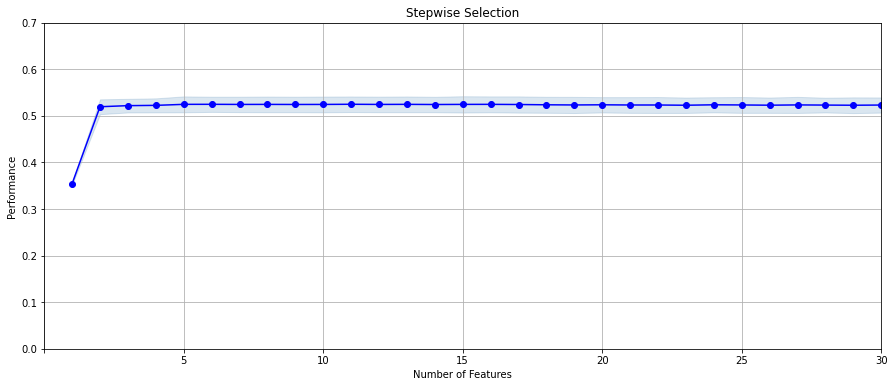

In [18]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
plt.xticks(np.arange(0, len(X.columns), step=5))
plt.ylim([0., .7])
plt.xlim(0,num_wrapper)
plt.title('Stepwise Selection')
plt.grid()
plt.savefig('FS_fdr.png')
plt.show()

In [19]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
vars_FS

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(3,)","[0.351732543966568, 0.3567821695977712]",0.354257,"(fulladdress_count_30,)",0.010863,0.002525,0.002525
2,"(3, 83)","[0.5035695629461954, 0.5354344419293052]",0.519502,"(fulladdress_count_30, ssn_dob_count_30)",0.068552,0.015932,0.015932
3,"(3, 10, 83)","[0.5072261884032736, 0.536479192059899]",0.521853,"(fulladdress_count_30, fulladdress_unique_coun...",0.062933,0.014627,0.014627
4,"(2, 3, 10, 83)","[0.5074003134250392, 0.5375239421904928]",0.522462,"(address_count_30, fulladdress_count_30, fulla...",0.064806,0.015062,0.015062
5,"(2, 3, 10, 13, 83)","[0.5075744384468048, 0.5417029427128678]",0.524639,"(address_count_30, fulladdress_count_30, fulla...",0.073422,0.017064,0.017064
6,"(2, 3, 10, 12, 13, 83)","[0.5084450635556329, 0.5410064426258053]",0.524726,"(address_count_30, fulladdress_count_30, fulla...",0.07005,0.016281,0.016281
7,"(2, 3, 10, 12, 13, 53, 83)","[0.5079226884903361, 0.5410064426258053]",0.524465,"(address_count_30, fulladdress_count_30, fulla...",0.071174,0.016542,0.016542
8,"(2, 3, 10, 12, 13, 30, 53, 83)","[0.5077485634685704, 0.5413546926693366]",0.524552,"(address_count_30, fulladdress_count_30, fulla...",0.072298,0.016803,0.016803
9,"(2, 3, 10, 12, 13, 21, 30, 53, 83)","[0.5077485634685704, 0.5410064426258053]",0.524378,"(address_count_30, fulladdress_count_30, fulla...",0.071549,0.016629,0.016629
10,"(2, 3, 10, 12, 13, 21, 30, 52, 53, 83)","[0.5075744384468048, 0.5413546926693366]",0.524465,"(address_count_30, fulladdress_count_30, fulla...",0.072672,0.01689,0.01689


In [20]:
vars_final = list(vars_FS.loc[num_wrapper, 'feature_names'])
vars_final

['address_count_30',
 'fulladdress_count_30',
 'address_count_14',
 'address_count_7',
 'fulladdress_unique_count_for_dob_homephone_60',
 'fulladdress_unique_count_for_ssn_lastname_60',
 'fulladdress_unique_count_for_ssn_zip5_60',
 'fulladdress_unique_count_for_ssn_fulladdress_60',
 'fulladdress_unique_count_for_name_dob_60',
 'fulladdress_unique_count_for_fulladdress_dob_60',
 'fulladdress_unique_count_for_ssn_name_30',
 'fulladdress_unique_count_for_ssn_lastname_30',
 'fulladdress_unique_count_for_ssn_zip5_30',
 'fulladdress_unique_count_for_name_dob_30',
 'fulladdress_unique_count_for_fulladdress_dob_30',
 'fulladdress_unique_count_for_ssn_fulladdress_14',
 'fulladdress_unique_count_for_fulladdress_dob_14',
 'fulladdress_unique_count_for_ssn_fulladdress_7',
 'fulladdress_unique_count_for_ssn_7',
 'fulladdress_unique_count_for_ssn_lastname_7',
 'fulladdress_unique_count_for_ssn_name_dob_7',
 'fulladdress_unique_count_for_fulladdress_dob_7',
 'fulladdress_unique_count_for_name_dob_7',

In [21]:
vars_FS.to_csv('VarsFS.csv', index=False)

In [22]:
sfs.subsets_

{1: {'feature_idx': (3,),
  'cv_scores': array([0.35173254, 0.35678217]),
  'avg_score': 0.35425735678216963,
  'feature_names': ('fulladdress_count_30',)},
 2: {'feature_idx': (3, 83),
  'cv_scores': array([0.50356956, 0.53543444]),
  'avg_score': 0.5195020024377504,
  'feature_names': ('fulladdress_count_30', 'ssn_dob_count_30')},
 3: {'feature_idx': (3, 10, 83),
  'cv_scores': array([0.50722619, 0.53647919]),
  'avg_score': 0.5218526902315863,
  'feature_names': ('fulladdress_count_30',
   'fulladdress_unique_count_for_dob_homephone_60',
   'ssn_dob_count_30')},
 4: {'feature_idx': (2, 3, 10, 83),
  'cv_scores': array([0.50740031, 0.53752394]),
  'avg_score': 0.522462127807766,
  'feature_names': ('address_count_30',
   'fulladdress_count_30',
   'fulladdress_unique_count_for_dob_homephone_60',
   'ssn_dob_count_30')},
 5: {'feature_idx': (2, 3, 10, 13, 83),
  'cv_scores': array([0.50757444, 0.54170294]),
  'avg_score': 0.5246386905798364,
  'feature_names': ('address_count_30',
   

In [23]:
vars_final.append('index_name')
vars_final.append('y_name')
vars_final

['address_count_30',
 'fulladdress_count_30',
 'address_count_14',
 'address_count_7',
 'fulladdress_unique_count_for_dob_homephone_60',
 'fulladdress_unique_count_for_ssn_lastname_60',
 'fulladdress_unique_count_for_ssn_zip5_60',
 'fulladdress_unique_count_for_ssn_fulladdress_60',
 'fulladdress_unique_count_for_name_dob_60',
 'fulladdress_unique_count_for_fulladdress_dob_60',
 'fulladdress_unique_count_for_ssn_name_30',
 'fulladdress_unique_count_for_ssn_lastname_30',
 'fulladdress_unique_count_for_ssn_zip5_30',
 'fulladdress_unique_count_for_name_dob_30',
 'fulladdress_unique_count_for_fulladdress_dob_30',
 'fulladdress_unique_count_for_ssn_fulladdress_14',
 'fulladdress_unique_count_for_fulladdress_dob_14',
 'fulladdress_unique_count_for_ssn_fulladdress_7',
 'fulladdress_unique_count_for_ssn_7',
 'fulladdress_unique_count_for_ssn_lastname_7',
 'fulladdress_unique_count_for_ssn_name_dob_7',
 'fulladdress_unique_count_for_fulladdress_dob_7',
 'fulladdress_unique_count_for_name_dob_7',

In [24]:
X_final = df_keep.filter(vars_final, axis=1)
X_final.shape

(794997, 30)

In [25]:
X_final.to_csv('vars_final.csv', index=False)

In [26]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 1:30:58.159382
